In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [36]:
# Load and preprocess the data
data_dir = 'data'

In [37]:
# Load dataset with a validation split = 30%
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(160, 160),
    batch_size=32,
    seed=42,
    validation_split=0.3,
    subset='training'
)

val_test_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(160, 160),
    batch_size=32,
    seed=42,
    validation_split=0.3,
    subset='validation'
)

Found 5740 files belonging to 22 classes.
Using 4018 files for training.
Found 5740 files belonging to 22 classes.
Using 1722 files for validation.


In [38]:
# Get the class names before mapping
class_names = data.class_names

In [39]:
# Split the val_test_data into validation and test sets
val_batches = tf.data.experimental.cardinality(val_test_data)
test_size = val_batches // 2
val_data = val_test_data.skip(test_size)
test_data = val_test_data.take(test_size)

In [40]:
# Normalize the images
data = data.map(lambda x, y: (x / 255.0, tf.one_hot(y, len(class_names))))
val_data = val_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, len(class_names))))
test_data = test_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, len(class_names))))

In [41]:
# Load pre-trained MobileNetV2 model + higher level layers
weights_path = 'mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160_no_top.h5'
base_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights=None)
base_model.load_weights(weights_path)
base_model.trainable = False  # Freeze the base model

In [42]:
# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
# Implement Early Stopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [44]:
# Train the model
history = model.fit(data, validation_data=val_data, epochs=100, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 57s 416ms/step - accuracy: 0.3330 - loss: 2.4705 - val_accuracy: 0.5606 - val_loss: 1.4211 - learning_rate: 1.0000e-04
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 314ms/step - accuracy: 0.5471 - loss: 1.5292 - val_accuracy: 0.6305 - val_loss: 1.1765 - learning_rate: 1.0000e-04
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 38s 301ms/step - accuracy: 0.5989 - loss: 1.2867 - val_accuracy: 0.6597 - val_loss: 1.0457 - learning_rate: 1.0000e-04
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 316ms/step - accuracy: 0.6399 - loss: 1.1468 - val_accuracy: 0.6923 - val_loss: 0.9480 - learning_rate: 1.0000e-04
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 332ms/step - accuracy: 0.6728 - loss: 1.0295 - val_accuracy: 0.7121 - val_loss: 0.8769 - learning_rate: 1.0000e-04
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 332ms/step - accuracy: 0.6972 - loss: 0.9398 - val_accuracy: 0.7226 - val_loss: 0.8442 - learning_rate: 1.0000e-04
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━

In [45]:
# Unfreeze some layers in the base model for fine-tuning
base_model.trainable = True
fine_tune_at = 100  # Fine-tune from this layer onwards

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
# Continue training the model
history_fine = model.fit(data, validation_data=val_data, epochs=100, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 54s 383ms/step - accuracy: 0.3762 - loss: 4.4419 - val_accuracy: 0.7704 - val_loss: 0.7008 - learning_rate: 1.0000e-05
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 331ms/step - accuracy: 0.4861 - loss: 2.2917 - val_accuracy: 0.7366 - val_loss: 0.8157 - learning_rate: 1.0000e-05
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 317ms/step - accuracy: 0.5397 - loss: 1.7721 - val_accuracy: 0.7121 - val_loss: 0.9535 - learning_rate: 1.0000e-05
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 54s 424ms/step - accuracy: 0.5900 - loss: 1.5206 - val_accuracy: 0.6993 - val_loss: 1.0123 - learning_rate: 1.0000e-05
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 57s 450ms/step - accuracy: 0.6199 - loss: 1.3054 - val_accuracy: 0.6958 - val_loss: 1.0833 - learning_rate: 1.0000e-05
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 57s 451ms/step - accuracy: 0.6531 - loss: 1.1562 - val_accuracy: 0.6783 - val_loss: 1.1766 - learning_rate: 1.0000e-05
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━

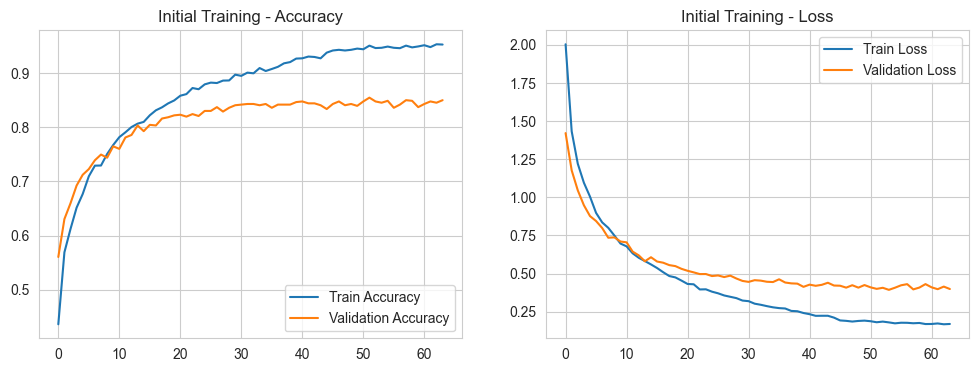

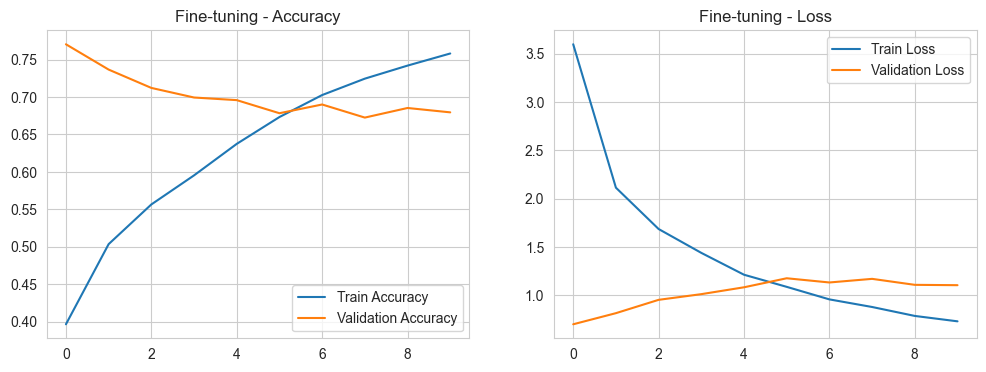

In [47]:
# Plot the training history
def plot_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.legend()
    ax1.set_title(f'{title} - Accuracy')

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.legend()
    ax2.set_title(f'{title} - Loss')

    plt.show()

plot_history(history, 'Initial Training')
plot_history(history_fine, 'Fine-tuning')

In [54]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_data)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - accuracy: 0.7789 - loss: 0.7153
Validation Accuracy: 78.32%
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.7680 - loss: 0.7398
Test Accuracy: 75.12%


In [55]:
# Generate confusion matrix for the test set
test_data_unbatched = test_data.unbatch()
y_pred = []
y_true = []

for x, y in test_data_unbatched:
    x = tf.expand_dims(x, axis=0)
    pred = model.predict(x)
    y_pred.append(np.argmax(pred))
    y_true.append(np.argmax(y.numpy()))

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Ensure the true and predicted labels contain the same number of classes
all_classes = np.arange(len(class_names))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=all_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

2024-06-06 14:53:06.564060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Confusion matrix, without normalization


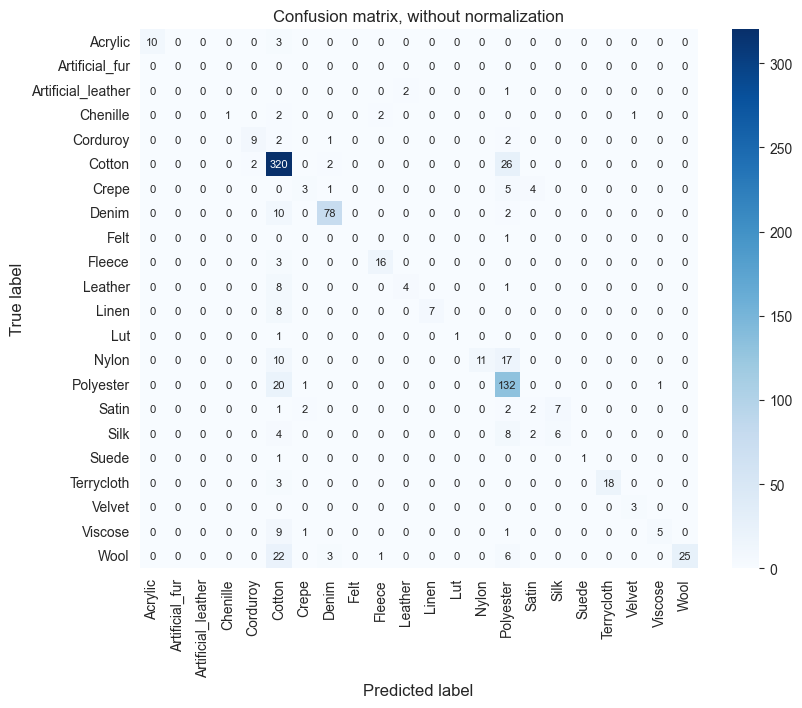

Normalized confusion matrix


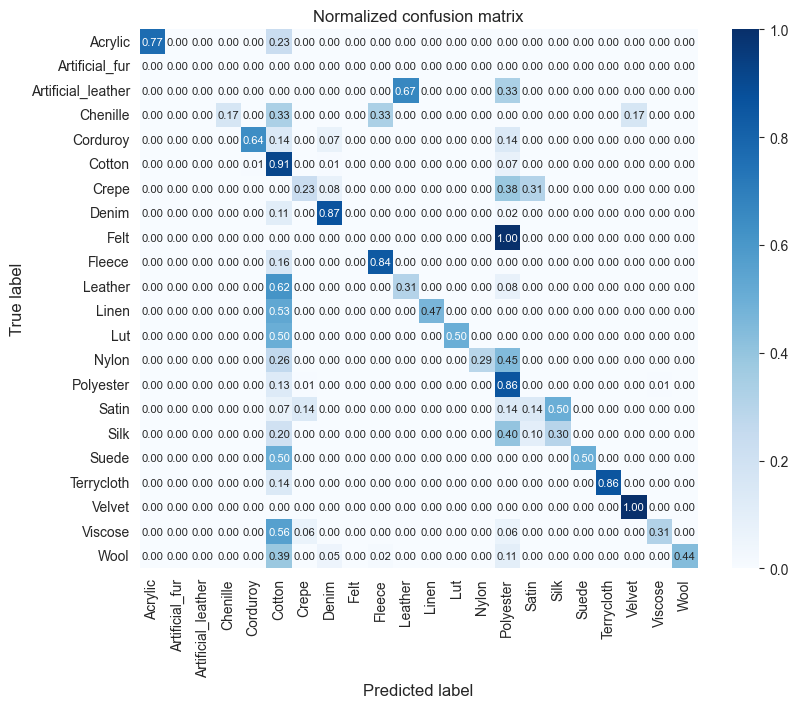

In [56]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        with np.errstate(all='ignore'):
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            cm = np.nan_to_num(cm)  # Replace nan with 0 and inf with large finite numbers
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
        
    plt.figure(figsize=(9, 7))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap, xticklabels=classes, yticklabels=classes, annot_kws={"size": 8})
    plt.title(title, fontsize=12)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized confusion matrix')


In [ ]:
import os

# File path for the saved model
model_file_path = './models/fabric_classification_model_v4.keras'  # Changed the file name to ensure it doesn't exist

# Check if the file already exists and remove it (optional, since we are using a new name)
if os.path.exists(model_file_path):
    os.remove(model_file_path)

# Save the trained model to a file using the recommended format
model.save(model_file_path)
